# Imports

Libraries:
-Numpy
-Pandas
-Tensorflow
-skelearn
-matplotlib
-datetime

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from numpy import array
from sklearn.metrics import root_mean_squared_error,mean_absolute_error #If you encounter an Import Error here, you will need to update scikit-learn.
from math import sqrt
tf.random.set_seed(42)
np.random.seed(42)
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Dropout
from keras.utils import plot_model
from keras.layers import SimpleRNN
from keras.optimizers import Adam
from keras.layers import LSTM, Input
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
# from scikeras.wrappers import KerasRegressor #Incompatible with tensorflow 2.10.0 and many other dependencies (cannot use)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import time

## Data preprocessing

### Downloading

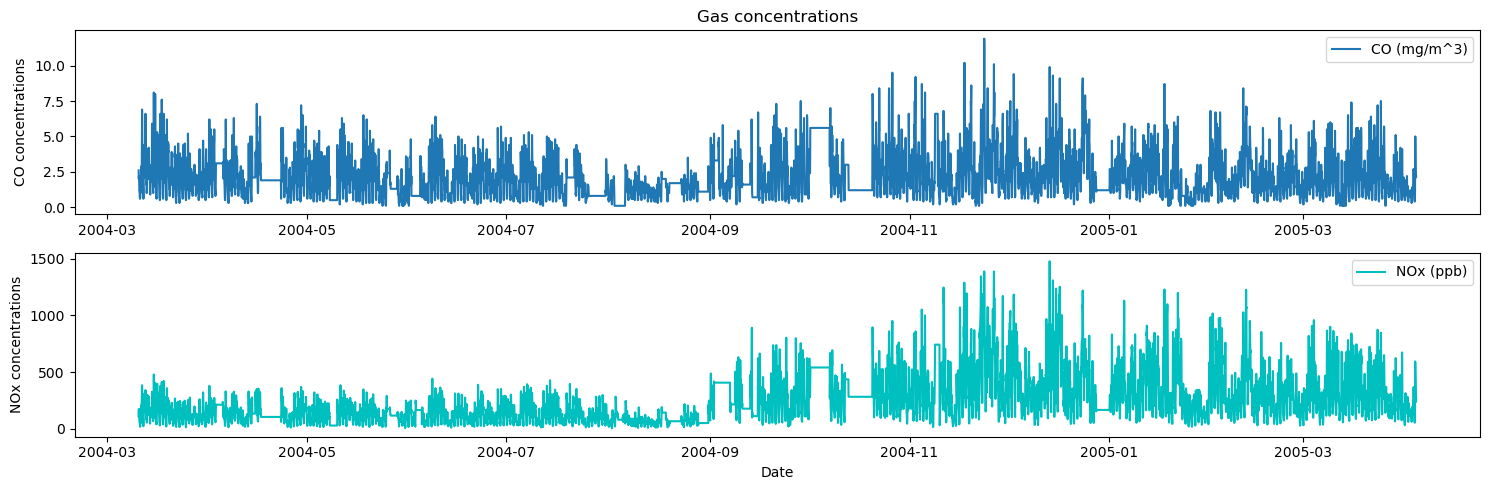

In [2]:
df= pd.read_csv("AirQualityUCI (Seperated).csv")
df = df.drop(df.columns[-2:], axis=1)
df.dropna(axis=0, how='any', inplace=True)
df['date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.set_index('date')
df.replace(-200, np.nan, inplace=True)
df_ff = df.ffill()
data=df_ff[['CO(GT)','NOx(GT)']]
# print("Missing values in each column:\n", data.isna().sum())
# data.head()
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
plt.plot(data['CO(GT)'], label='CO (mg/m^3)')
plt.ylabel('CO concentrations')
plt.title('Gas concentrations')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['NOx(GT)'],label='NOx (ppb)',color='c')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')
plt.legend()

plt.tight_layout()

### Scaling and Splitting

In [3]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

In [4]:
train, test = train_test_split(scaled_data, test_size=0.2, shuffle=False)
print(f'Training Data Size: {len(train)}')
print(f'Testing Data Size: {len(test)}')

Training Data Size: 7485
Testing Data Size: 1872


In [5]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence.iloc[i:end_ix], sequence.iloc[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y) 

In [6]:
n_steps=24
X_train, y_train = split_sequence(train, n_steps)
X_test, y_test = split_sequence(test, n_steps)
# print(X_train.shape)
# print(y_train.shape)

# print(X_test.shape)
# print(y_test.shape)

In [7]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# print(n_timesteps)
# print(n_features)
# print(n_outputs)

<font size="6">Restart kernel and run again if experiencing vanishing gradient</font>

# RNN


### Training

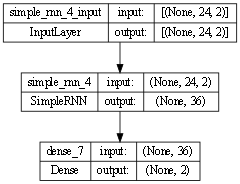

In [49]:
#Initialize model
hidden_size=36
model_rnn=Sequential()
model_rnn.add(SimpleRNN(units=hidden_size,activation='relu', input_shape=(n_timesteps, n_features)))
model_rnn.add(Dense(n_outputs))
model_rnn.compile(loss='mean_squared_logarithmic_error',optimizer=Adam(learning_rate=1e-3)) #loss function not specified, using mean absolute error
plot_model(model_rnn, show_shapes=True, show_layer_names=True,dpi=60)

In [50]:
#Train model
start_rnn=time.time()

epochs_rnn=50
batch_size_rnn=16
validation_split=0.2 #No mention of validation set size, assuming 0.2 of training set
model_rnn_trained=model_rnn.fit(X_train, y_train, epochs=epochs_rnn, batch_size=batch_size_rnn, verbose=True, validation_split=validation_split, shuffle=True)

end_rnn=time.time()
time_rnn=(end_rnn-start_rnn)/60
print(f"Elapsed time: {time_rnn:.4f} minutes")

Epoch 1/50
373/373 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 2/50
373/373 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 3/50
373/373 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 4/50
373/373 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 5/50
373/373 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 6/50
373/373 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 7/50
373/373 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 8/50
373/373 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 9/50
373/373 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 10/50
373/373 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0030

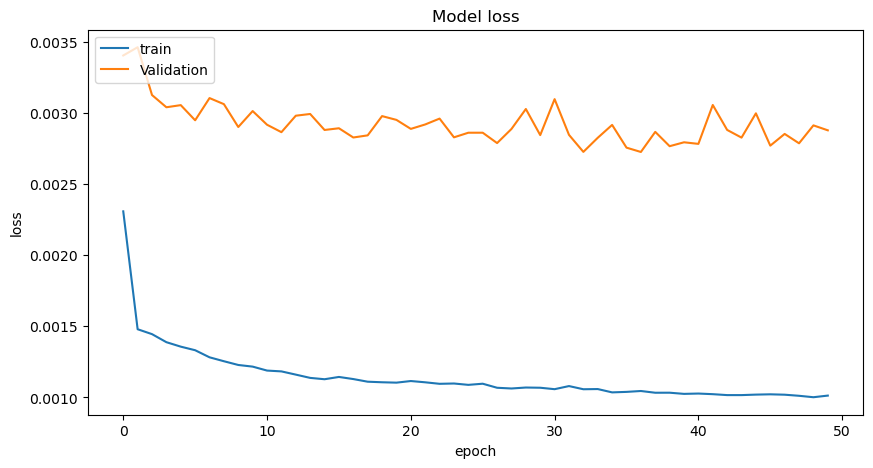

In [54]:
#Validation loss check
plt.figure(figsize=(10, 5))
plt.plot(model_rnn_trained.history['loss'])
plt.plot(model_rnn_trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

### Testing

58/58 [==============================] - 0s 3ms/step
RMSE for CO: 0.6228685530801898
MAE for CO: 0.43143798800646954
RMSE for NOx: 93.55643507224146
MAE for NOx: 63.12340357086875


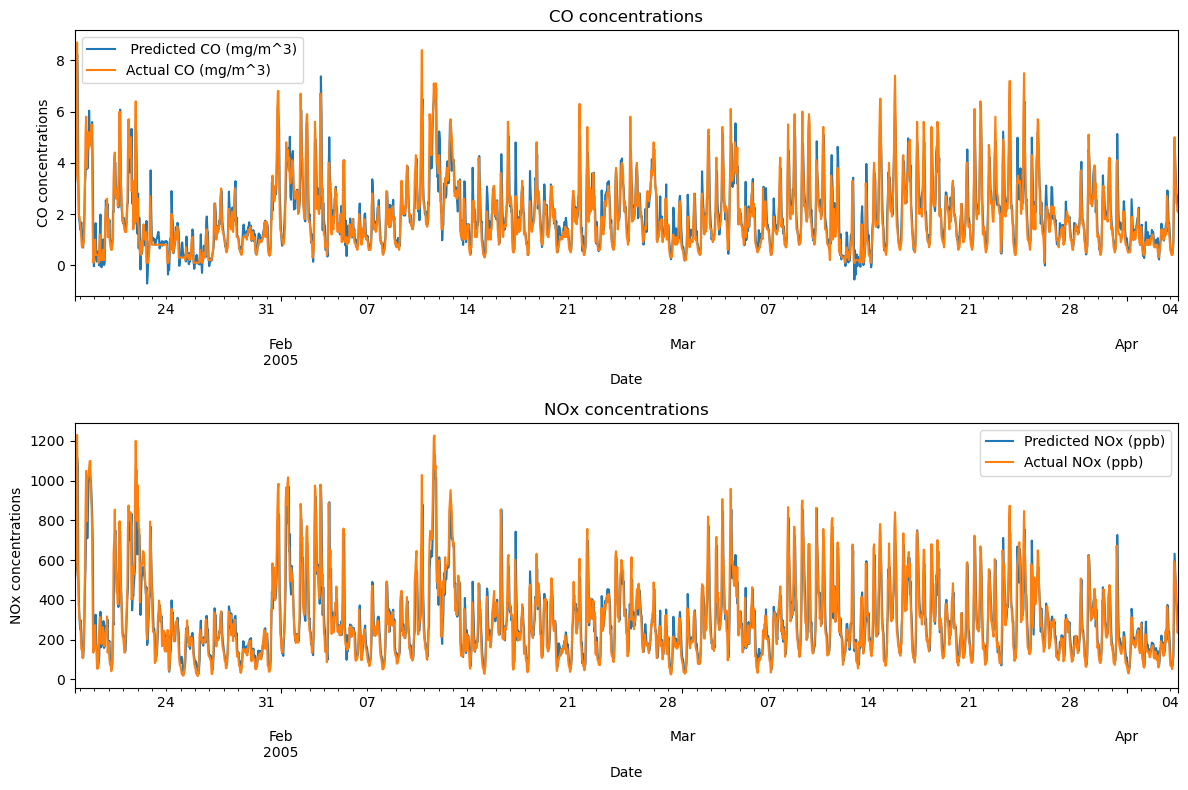

In [52]:
# Get the predictions for the test set
pred_rnn = model_rnn.predict(X_test).flatten()
pred_rnn = scaler.inverse_transform(pred_rnn.reshape(-1, n_outputs))
pred_rnn=pd.DataFrame(pred_rnn, columns=['Pred_CO', 'Pred_NOx'])
valid_test=scaler.inverse_transform(test[n_timesteps:]) #New time series to accomodate 10 day lag between predictions and testing data
valid_test = pd.DataFrame(valid_test, columns=test[n_timesteps:].columns, index=test[n_timesteps:].index)
pred_rnn.index=valid_test.index

#Metrics calculations (RMSE and MAE)
rmse_rnn_co=root_mean_squared_error(pred_rnn['Pred_CO'],valid_test['CO(GT)'])
print('RMSE for CO: '+str(rmse_rnn_co))
mae_rnn_co=mean_absolute_error(pred_rnn['Pred_CO'],valid_test['CO(GT)'])
print('MAE for CO: '+str(mae_rnn_co))

rmse_rnn_nox=root_mean_squared_error(pred_rnn['Pred_NOx'],valid_test['NOx(GT)'])
print('RMSE for NOx: '+str(rmse_rnn_nox))
mae_rnn_nox=mean_absolute_error(pred_rnn['Pred_NOx'],valid_test['NOx(GT)'])
print('MAE for NOx: '+str(mae_rnn_nox))

plt.figure(figsize=(12, 8))
# Same plot

plt.subplot(2,1,1)
pred_rnn['Pred_CO'].plot(title= 'CO concentrations',legend=True, label=' Predicted CO (mg/m^3)')
valid_test['CO(GT)'].plot(legend=True, label='Actual CO (mg/m^3)')
plt.xlabel('Date')
plt.ylabel('CO concentrations')


plt.subplot(2,1,2)
pred_rnn['Pred_NOx'].plot(title= 'NOx concentrations',legend=True, label='Predicted NOx (ppb)')
valid_test['NOx(GT)'].plot(legend=True, label='Actual NOx (ppb)')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')

plt.tight_layout()

### Predicting

In [36]:
n_predictions = 1000  # Total number of hours to predict (8760 for full year prediction)
start=y_test[-n_timesteps:] #Last 24 hrs of data

# Initialize predictions array
predictions_rnn = np.empty((0,2))
predictions_rnn=np.append(predictions_rnn,start,axis=0)
window = start.reshape(1,n_timesteps,n_outputs)

print('Starting predictions:')
# Iteratively predict one row at a time and update window to be the last 24 rows
for k in range(n_predictions):
    # Predict the next row (1 hour)
    next_value = model_rnn.predict(window, verbose=False)
    noise=next_value * 0.1 * np.random.uniform(-1, 1, size=next_value.shape)
    next_value=next_value+noise

    # Append the prediction to the result array
    predictions_rnn=np.append(predictions_rnn,next_value,axis=0)

    # Update the sliding window
    window = predictions_rnn[-n_timesteps:].reshape(1,n_timesteps,n_outputs)
    print('Day: '+ str(int(k/24)) + ' Hour: '+ str(k%24)) #Printing output to check on program progress

#Unscale data and remove the first 24 rows (as they belong to the original dataset and should not be part of the predictions)
true_predictions_rnn=scaler.inverse_transform(predictions_rnn)
true_predictions_rnn=pd.DataFrame(true_predictions_rnn[n_timesteps:,:],columns=['Future CO (mg/m^3)', 'Future NOx (ppb)'])

#Initialize the index start, end and apply them to predictions
start_time = datetime(2005, 4, 4, 15, 0, 0)
end_time = start_time + timedelta(hours=n_predictions-1)
index_future_dates=pd.date_range(start=start_time,end=end_time, freq='h')
true_predictions_rnn.index=index_future_dates
true_predictions_rnn.tail(5) #Checking output for oddities

Starting predictions:
Day: 0 Hour: 0
Day: 0 Hour: 1
Day: 0 Hour: 2
Day: 0 Hour: 3
Day: 0 Hour: 4
Day: 0 Hour: 5
Day: 0 Hour: 6
Day: 0 Hour: 7
Day: 0 Hour: 8
Day: 0 Hour: 9
Day: 0 Hour: 10
Day: 0 Hour: 11
Day: 0 Hour: 12
Day: 0 Hour: 13
Day: 0 Hour: 14
Day: 0 Hour: 15
Day: 0 Hour: 16
Day: 0 Hour: 17
Day: 0 Hour: 18
Day: 0 Hour: 19
Day: 0 Hour: 20
Day: 0 Hour: 21
Day: 0 Hour: 22
Day: 0 Hour: 23
Day: 1 Hour: 0
Day: 1 Hour: 1
Day: 1 Hour: 2
Day: 1 Hour: 3
Day: 1 Hour: 4
Day: 1 Hour: 5
Day: 1 Hour: 6
Day: 1 Hour: 7
Day: 1 Hour: 8
Day: 1 Hour: 9
Day: 1 Hour: 10
Day: 1 Hour: 11
Day: 1 Hour: 12
Day: 1 Hour: 13
Day: 1 Hour: 14
Day: 1 Hour: 15
Day: 1 Hour: 16
Day: 1 Hour: 17
Day: 1 Hour: 18
Day: 1 Hour: 19
Day: 1 Hour: 20
Day: 1 Hour: 21
Day: 1 Hour: 22
Day: 1 Hour: 23
Day: 2 Hour: 0
Day: 2 Hour: 1
Day: 2 Hour: 2
Day: 2 Hour: 3
Day: 2 Hour: 4
Day: 2 Hour: 5
Day: 2 Hour: 6
Day: 2 Hour: 7
Day: 2 Hour: 8
Day: 2 Hour: 9
Day: 2 Hour: 10
Day: 2 Hour: 11
Day: 2 Hour: 12
Day: 2 Hour: 13
Day: 2 Hour: 14


Future CO (mg/m^3)  Future NOx (ppb)
2005-05-16 02:00:00            4.057503        274.514480
2005-05-16 03:00:00            4.313226        286.760487
2005-05-16 04:00:00            3.504125        249.668027
2005-05-16 05:00:00            2.592129        196.597360
2005-05-16 06:00:00            2.363920        179.967843

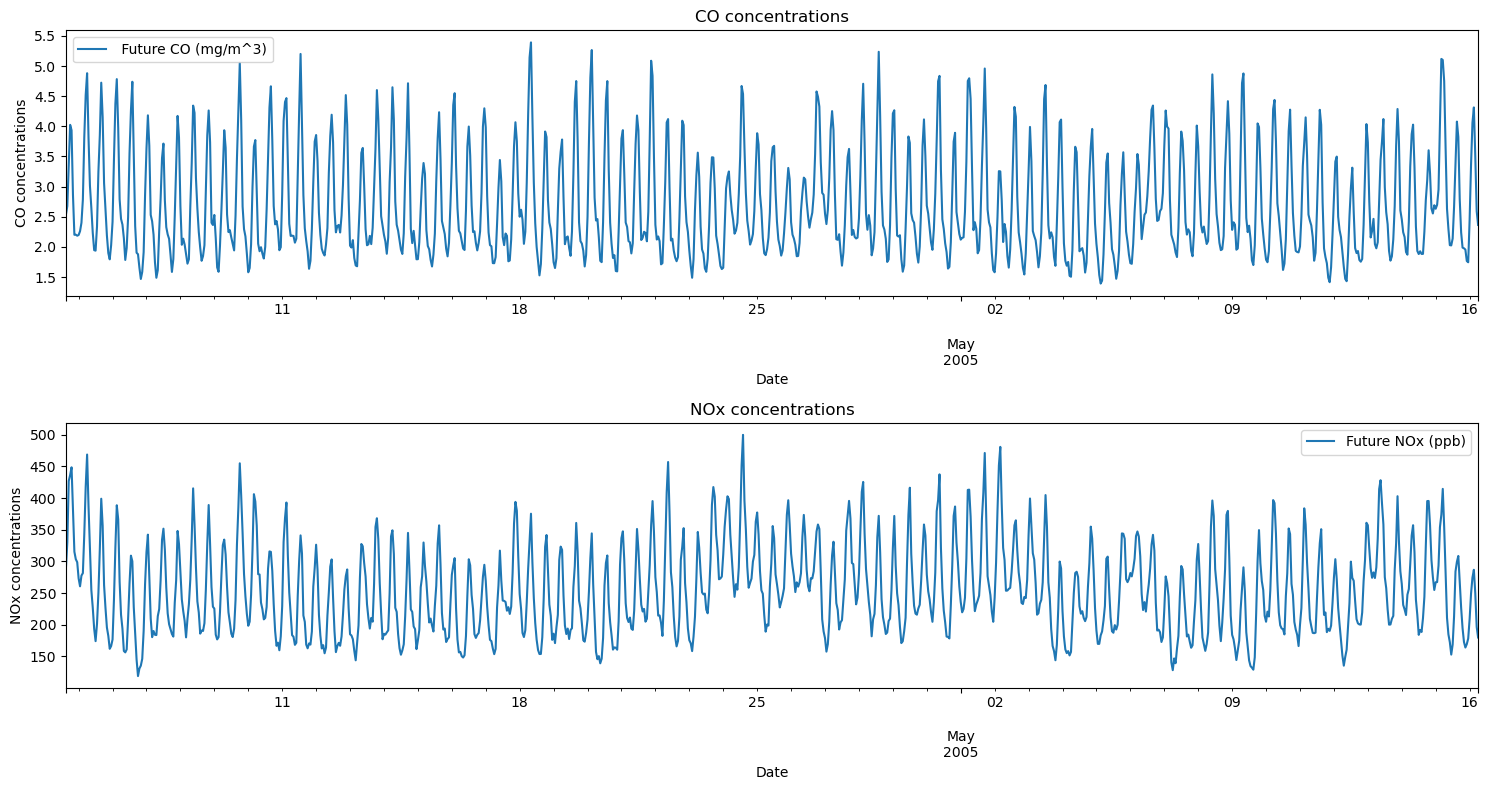

In [58]:
plt.figure(figsize=(15, 8))
# Visualizing the predictions
plt.subplot(2,1,1)
true_predictions_rnn['Future CO (mg/m^3)'].plot(title= 'CO concentrations',legend=True, label=' Future CO (mg/m^3)')
plt.xlabel('Date')
plt.ylabel('CO concentrations')

plt.subplot(2,1,2)
true_predictions_rnn['Future NOx (ppb)'].plot(title= 'NOx concentrations',legend=True, label='Future NOx (ppb)')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')

plt.tight_layout()

In [ ]:
#Put the file in a csv (to pass it on to the next algorithm without running the entire code)
true_predictions_rnn.index.name='Date'
true_predictions_rnn.to_csv("RNN predictions.csv", index=True)

# LSTM

### Training

In [8]:
#Initialize model
model_lstm_norm = Sequential()
model_lstm_norm.add(LSTM(60, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
model_lstm_norm.add(LSTM(36, activation='relu'))
model_lstm_norm.add(Dense(n_outputs, activation='relu'))
model_lstm_norm.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

In [9]:
#Train model
start_lstm=time.time()

epochs_lstm=50
batch_size_lstm=32
validation_split=0.2 #No mention of validation set size, assuming 0.2 of training set
model_lstm_norm_trained=model_lstm_norm.fit(X_train, y_train, epochs=epochs_lstm, batch_size=batch_size_lstm, verbose=True, validation_split=validation_split, shuffle=True)

end_lstm=time.time()
time_lstm=(end_lstm-start_lstm)/60
print(f"Elapsed time: {time_lstm:.4f} minutes")

Epoch 1/50
187/187 [==============================] - 6s 19ms/step - loss: 0.0084 - val_loss: 0.0154
Epoch 2/50
187/187 [==============================] - 3s 17ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 3/50
187/187 [==============================] - 3s 17ms/step - loss: 0.0034 - val_loss: 0.0079
Epoch 4/50
187/187 [==============================] - 3s 17ms/step - loss: 0.0026 - val_loss: 0.0063
Epoch 5/50
187/187 [==============================] - 3s 17ms/step - loss: 0.0025 - val_loss: 0.0063
Epoch 6/50
187/187 [==============================] - 3s 17ms/step - loss: 0.0024 - val_loss: 0.0061
Epoch 7/50
187/187 [==============================] - 3s 17ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 8/50
187/187 [==============================] - 3s 17ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 9/50
187/187 [==============================] - 3s 18ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 10/50
187/187 [==============================] - 3s 17ms/step - loss: 0.0022 - val_lo

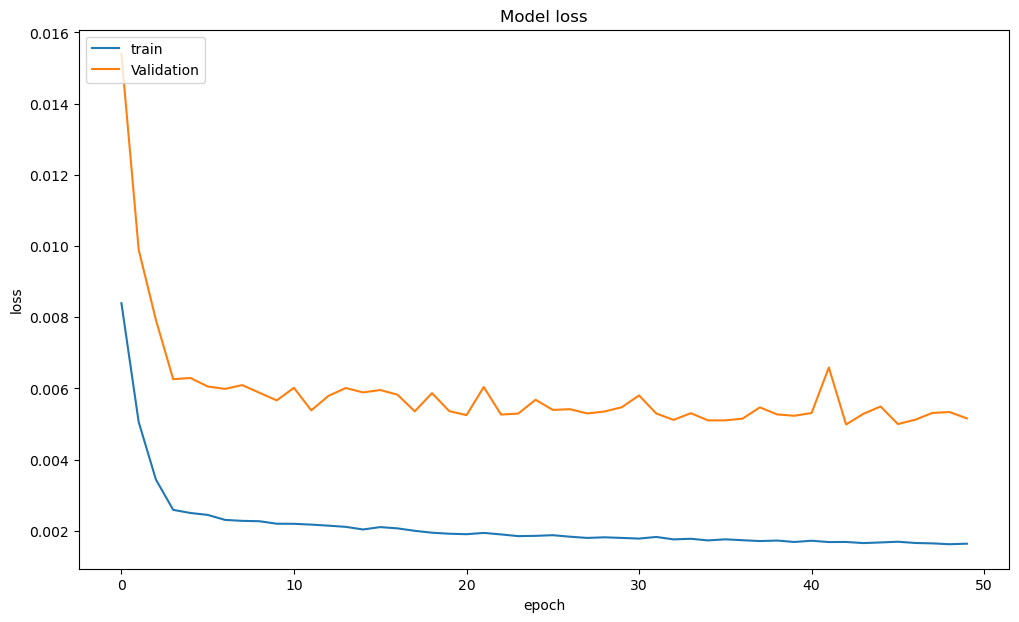

In [61]:
#Validation loss check
plt.figure(figsize=(12, 7))
plt.plot(model_lstm_norm_trained.history['loss'])
plt.plot(model_lstm_norm_trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

### Testing

58/58 [==============================] - 1s 8ms/step
RMSE for CO: 0.6667949503528008
MAE for CO: 0.49757632475297947
RMSE for NOx: 91.9600969684343
MAE for NOx: 64.46648981251242


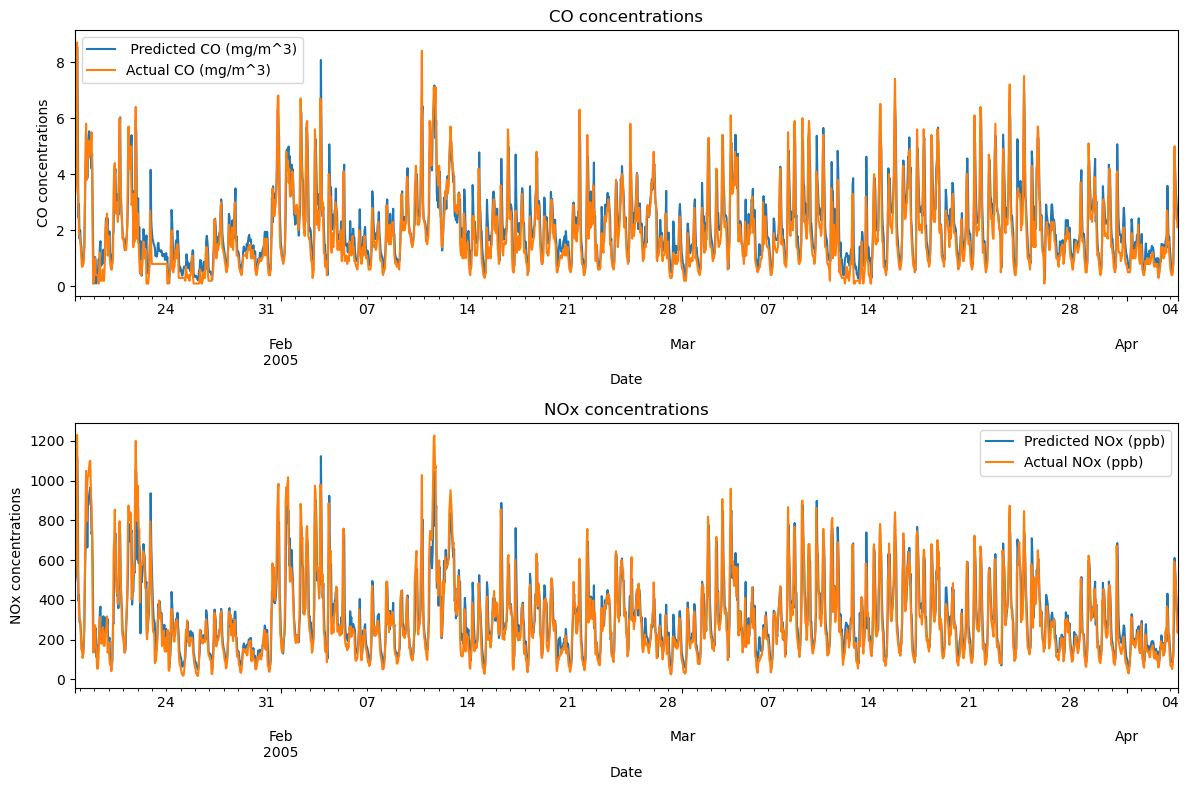

In [11]:
# Get the predictions for the test set
pred_lstm_norm = model_lstm_norm.predict(X_test).flatten()
pred_lstm_norm = scaler.inverse_transform(pred_lstm_norm.reshape(-1, n_outputs))
pred_lstm_norm=pd.DataFrame(pred_lstm_norm, columns=['Pred_CO', 'Pred_NOx'])
valid_test=scaler.inverse_transform(test[n_timesteps:]) #New time series to accomodate 10 day lag between predictions and testing data
valid_test = pd.DataFrame(valid_test, columns=test[n_timesteps:].columns, index=test[n_timesteps:].index)
pred_lstm_norm.index=valid_test.index

#Metrics calculations
rmse_lstm_norm_co=root_mean_squared_error(pred_lstm_norm['Pred_CO'],valid_test['CO(GT)'])
print('RMSE for CO: '+str(rmse_lstm_norm_co))
mae_lstm_norm_co=mean_absolute_error(pred_lstm_norm['Pred_CO'],valid_test['CO(GT)'])
print('MAE for CO: '+str(mae_lstm_norm_co))

rmse_lstm_norm_nox=root_mean_squared_error(pred_lstm_norm['Pred_NOx'],valid_test['NOx(GT)'])
print('RMSE for NOx: '+str(rmse_lstm_norm_nox))
mae_lstm_norm_nox=mean_absolute_error(pred_lstm_norm['Pred_NOx'],valid_test['NOx(GT)'])
print('MAE for NOx: '+str(mae_lstm_norm_nox))

plt.figure(figsize=(12, 8))

#Model performance comparison
plt.subplot(2,1,1)
pred_lstm_norm['Pred_CO'].plot(title= 'CO concentrations',legend=True, label=' Predicted CO (mg/m^3)')
valid_test['CO(GT)'].plot(legend=True, label='Actual CO (mg/m^3)')
plt.xlabel('Date')
plt.ylabel('CO concentrations')


plt.subplot(2,1,2)
pred_lstm_norm['Pred_NOx'].plot(title= 'NOx concentrations',legend=True, label='Predicted NOx (ppb)')
valid_test['NOx(GT)'].plot(legend=True, label='Actual NOx (ppb)')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')

plt.tight_layout()

### Predicting

In [64]:
n_predictions = 1000  # Total number of hours to predict (8760 for full year prediction)
start=y_test[-n_timesteps:] #Last 24 hrs of data

# Initialize predictions array
predictions_lstm_norm = np.empty((0,2))
predictions_lstm_norm=np.append(predictions_lstm_norm,start,axis=0)
window = start.reshape(1,n_timesteps,n_outputs)

print('Starting predictions:')
# Iteratively predict one timestep at a time
for k in range(n_predictions):
    # Predict the next row (1 hour)
    next_value = model_lstm_norm.predict(window, verbose=False)
    noise=next_value * 0.1 * np.random.uniform(-1, 1, size=next_value.shape)
    next_value=next_value+noise

    # Append the prediction to the predictions array
    predictions_lstm_norm=np.append(predictions_lstm_norm,next_value,axis=0)

    # Update the sliding window
    window = predictions_lstm_norm[-n_timesteps:].reshape(1,n_timesteps,n_outputs)
    print('Day: '+ str(int(k/24)) + ' Hour: '+ str(k%24))

#Unscale the data and remove first 24 rows of predictions
true_predictions_lstm_norm=scaler.inverse_transform(predictions_lstm_norm)
true_predictions_lstm_norm=pd.DataFrame(true_predictions_lstm_norm[n_timesteps:,:],columns=['Future CO (mg/m^3)', 'Future NOx (ppb)'])

#Create future indexes and assign them to future predictions
start_time = datetime(2005, 4, 4, 15, 0, 0)
end_time = start_time + timedelta(hours=n_predictions-1)
index_future_dates=pd.date_range(start=start_time,end=end_time, freq='h')
true_predictions_lstm_norm.index=index_future_dates
true_predictions_lstm_norm.tail(5)

Starting predictions:
Day: 0 Hour: 0
Day: 0 Hour: 1
Day: 0 Hour: 2
Day: 0 Hour: 3
Day: 0 Hour: 4
Day: 0 Hour: 5
Day: 0 Hour: 6
Day: 0 Hour: 7
Day: 0 Hour: 8
Day: 0 Hour: 9
Day: 0 Hour: 10
Day: 0 Hour: 11
Day: 0 Hour: 12
Day: 0 Hour: 13
Day: 0 Hour: 14
Day: 0 Hour: 15
Day: 0 Hour: 16
Day: 0 Hour: 17
Day: 0 Hour: 18
Day: 0 Hour: 19
Day: 0 Hour: 20
Day: 0 Hour: 21
Day: 0 Hour: 22
Day: 0 Hour: 23
Day: 1 Hour: 0
Day: 1 Hour: 1
Day: 1 Hour: 2
Day: 1 Hour: 3
Day: 1 Hour: 4
Day: 1 Hour: 5
Day: 1 Hour: 6
Day: 1 Hour: 7
Day: 1 Hour: 8
Day: 1 Hour: 9
Day: 1 Hour: 10
Day: 1 Hour: 11
Day: 1 Hour: 12
Day: 1 Hour: 13
Day: 1 Hour: 14
Day: 1 Hour: 15
Day: 1 Hour: 16
Day: 1 Hour: 17
Day: 1 Hour: 18
Day: 1 Hour: 19
Day: 1 Hour: 20
Day: 1 Hour: 21
Day: 1 Hour: 22
Day: 1 Hour: 23
Day: 2 Hour: 0
Day: 2 Hour: 1
Day: 2 Hour: 2
Day: 2 Hour: 3
Day: 2 Hour: 4
Day: 2 Hour: 5
Day: 2 Hour: 6
Day: 2 Hour: 7
Day: 2 Hour: 8
Day: 2 Hour: 9
Day: 2 Hour: 10
Day: 2 Hour: 11
Day: 2 Hour: 12
Day: 2 Hour: 13
Day: 2 Hour: 14


Future CO (mg/m^3)  Future NOx (ppb)
2005-05-16 02:00:00            2.539191        435.259182
2005-05-16 03:00:00            2.641882        412.656697
2005-05-16 04:00:00            2.590070        417.553113
2005-05-16 05:00:00            2.519714        464.835472
2005-05-16 06:00:00            2.319209        512.999555

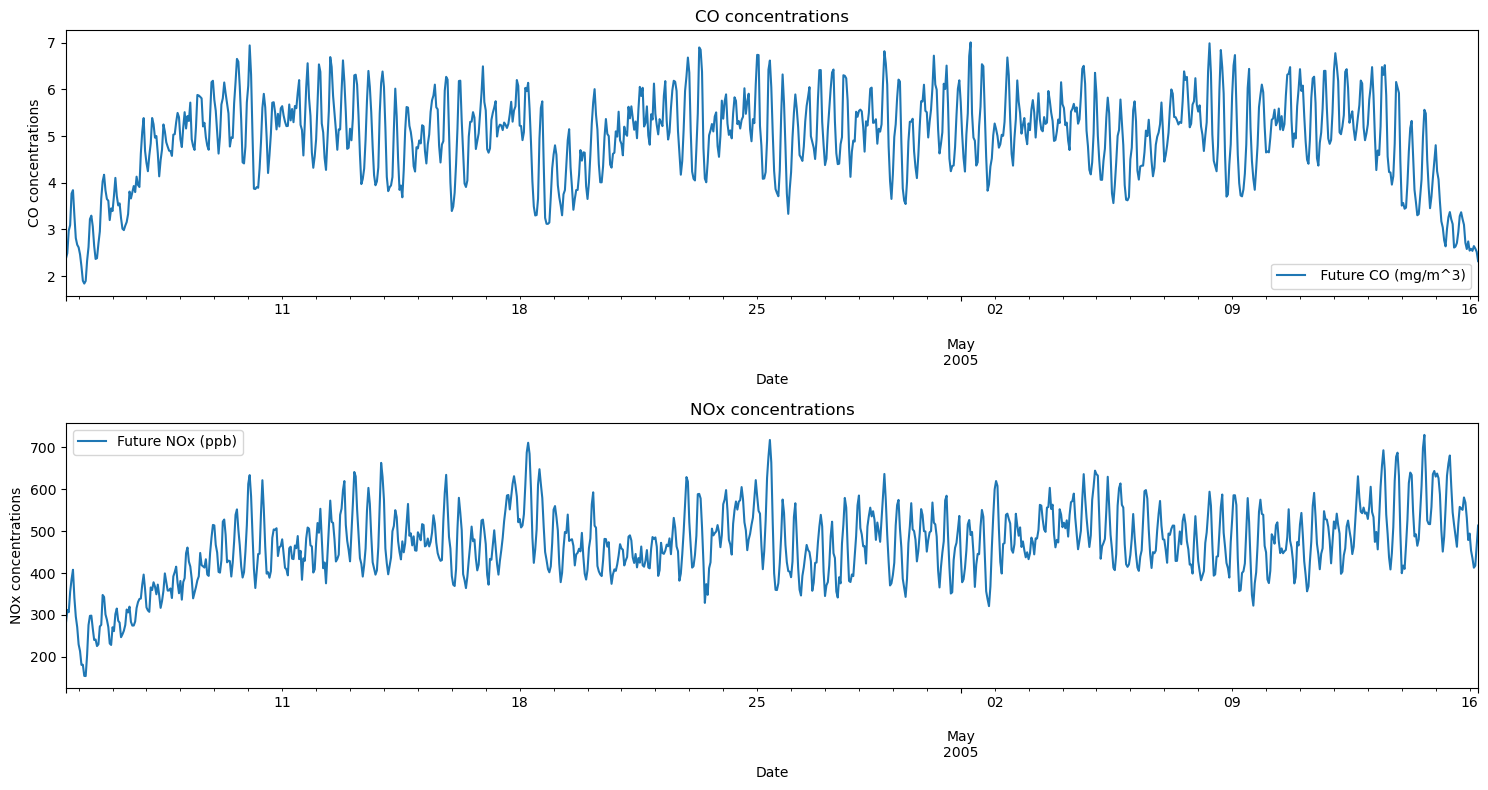

In [66]:
plt.figure(figsize=(15, 8))
# Same plot
#Visualizing future predictions
plt.subplot(2,1,1)
true_predictions_lstm_norm['Future CO (mg/m^3)'].plot(title= 'CO concentrations',legend=True, label=' Future CO (mg/m^3)')
plt.xlabel('Date')
plt.ylabel('CO concentrations')

plt.subplot(2,1,2)
true_predictions_lstm_norm['Future NOx (ppb)'].plot(title= 'NOx concentrations',legend=True, label='Future NOx (ppb)')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')

plt.tight_layout()

In [ ]:
#Putting results in csv to pass on to next algorithm
true_predictions_lstm_norm.index.name='Date'
true_predictions_lstm_norm.to_csv("LSTM predictions.csv", index=True)

# GRU

### Training

In [41]:
#Initialize the model
model_gru= Sequential()
model_gru.add(GRU(60,activation='relu', input_shape=(n_timesteps,n_features), return_sequences=True))
model_gru.add(GRU(36,activation='relu'))
model_gru.add(Dense(n_outputs))
model_gru.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=1e-3)) #loss function not specified, using mean absolute error

In [42]:
#Training the model
start_gru=time.time()

epochs_gru=50
batch_size_gru=32
validation_split=0.2
model_gru_trained=model_gru.fit(X_train, y_train, epochs=epochs_gru, batch_size=batch_size_gru, verbose=True, validation_split=validation_split, shuffle=True)

end_gru=time.time()
time_gru=(end_gru-start_gru)/60
print(f"Elapsed time: {time_gru:.4f} minutes")

Epoch 1/50
187/187 [==============================] - 6s 20ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 2/50
187/187 [==============================] - 4s 19ms/step - loss: 0.0029 - val_loss: 0.0071
Epoch 3/50
187/187 [==============================] - 4s 19ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 4/50
187/187 [==============================] - 4s 20ms/step - loss: 0.0024 - val_loss: 0.0059
Epoch 5/50
187/187 [==============================] - 4s 20ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 6/50
187/187 [==============================] - 4s 19ms/step - loss: 0.0022 - val_loss: 0.0056
Epoch 7/50
187/187 [==============================] - 4s 19ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 8/50
187/187 [==============================] - 4s 19ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 9/50
187/187 [==============================] - 4s 19ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 10/50
187/187 [==============================] - 4s 19ms/step - loss: 0.0021 - val_lo

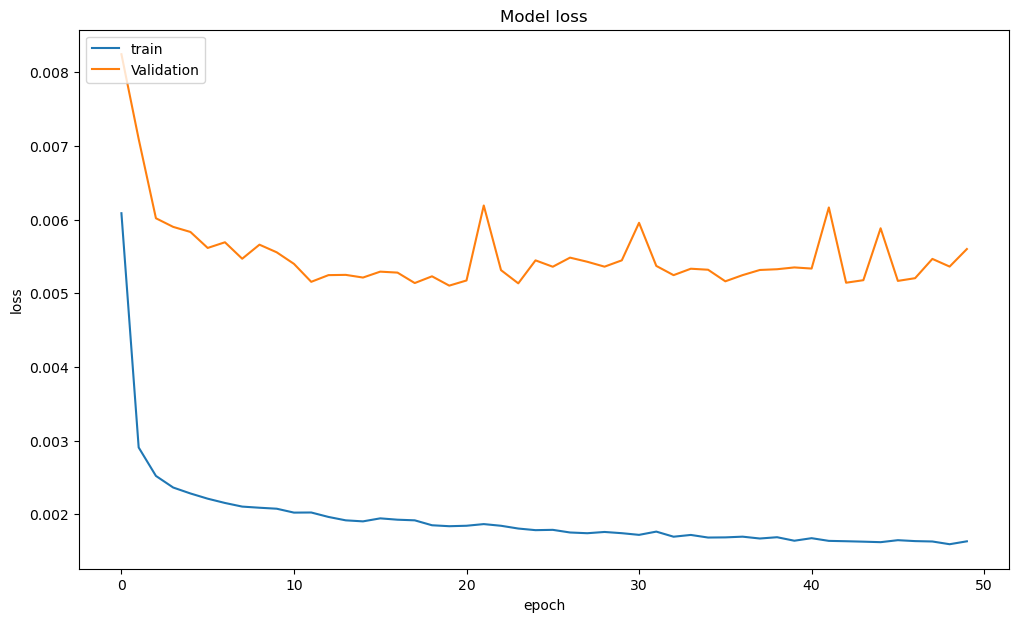

In [67]:
#Validation loss check
plt.figure(figsize=(12, 7))
plt.plot(model_gru_trained.history['loss'])
plt.plot(model_gru_trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

### Testing

58/58 [==============================] - 1s 10ms/step
RMSE for CO: 0.7044446019647708
MAE for CO: 0.5322121442210945
RMSE for NOx: 90.26749096772195
MAE for NOx: 62.295489951129596


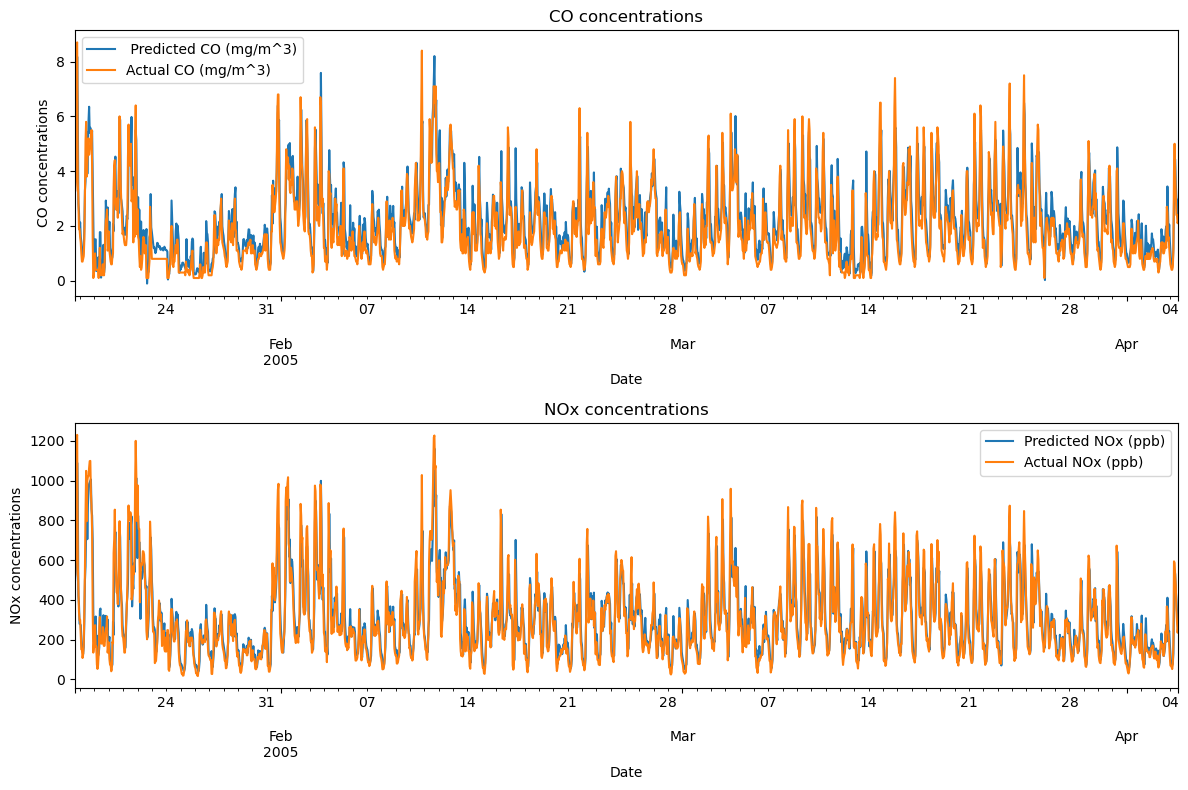

In [47]:
# Get the predictions for the test set
pred_gru = model_gru.predict(X_test).flatten()
pred_gru = scaler.inverse_transform(pred_gru.reshape(-1, 2))
pred_gru=pd.DataFrame(pred_gru, columns=['Pred_CO', 'Pred_NOx'])
valid_test=scaler.inverse_transform(test[n_timesteps:]) #New time series to accomodate 10 day lag between predictions and testing data
valid_test = pd.DataFrame(valid_test, columns=test[n_timesteps:].columns, index=test[n_timesteps:].index)
pred_gru.index=valid_test.index

#Metrics calculations
rmse_gru_co=root_mean_squared_error(pred_gru['Pred_CO'],valid_test['CO(GT)'])
print('RMSE for CO: '+str(rmse_gru_co))
mae_gru_co=mean_absolute_error(pred_gru['Pred_CO'],valid_test['CO(GT)'])
print('MAE for CO: '+str(mae_gru_co))

rmse_gru_nox=root_mean_squared_error(pred_gru['Pred_NOx'],valid_test['NOx(GT)'])
print('RMSE for NOx: '+str(rmse_gru_nox))
mae_gru_nox=mean_absolute_error(pred_gru['Pred_NOx'],valid_test['NOx(GT)'])
print('MAE for NOx: '+str(mae_gru_nox))

plt.figure(figsize=(12, 8))

#comparing predicitons using training data with testing data
plt.subplot(2,1,1)
pred_gru['Pred_CO'].plot(title= 'CO concentrations',legend=True, label=' Predicted CO (mg/m^3)')
valid_test['CO(GT)'].plot(legend=True, label='Actual CO (mg/m^3)')
plt.xlabel('Date')
plt.ylabel('CO concentrations')


plt.subplot(2,1,2)
pred_gru['Pred_NOx'].plot(title= 'NOx concentrations',legend=True, label='Predicted NOx (ppb)')
valid_test['NOx(GT)'].plot(legend=True, label='Actual NOx (ppb)')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')

plt.tight_layout()

### Predicting

In [45]:
n_predictions = 1000  # Total number of hours to predict (8760 for full year)
start=y_test[-n_timesteps:] #Last 24 hrrs of data

# Initialize predictions list
predictions_gru = np.empty((0,2))
predictions_gru=np.append(predictions_gru,start,axis=0)
window = start.reshape(1,n_timesteps,n_outputs)

print('Starting predictions:')
# Iteratively predict one row at a time
for k in range(n_predictions):
    # Predict the next row (1 hour)
    next_value = model_gru.predict(window, verbose=False)
    noise=next_value * 0.1 * np.random.uniform(-1, 1, size=next_value.shape)
    next_value=next_value+noise

    # Append the prediction to the prediction array
    predictions_gru=np.append(predictions_gru,next_value,axis=0)

    # Update the sliding window
    window = predictions_gru[-n_timesteps:].reshape(1,n_timesteps,n_outputs)
    print('Day: '+ str(int(k/24)) + ' Hour: '+ str(k%24))

true_predictions_gru=scaler.inverse_transform(predictions_gru)
true_predictions_gru=pd.DataFrame(true_predictions_gru[n_timesteps:,:],columns=['Future CO (mg/m^3)', 'Future NOx (ppb)'])

start_time = datetime(2005, 4, 4, 15, 0, 0)
end_time = start_time + timedelta(hours=n_predictions-1)
index_future_dates=pd.date_range(start=start_time,end=end_time, freq='h')
true_predictions_gru.index=index_future_dates
true_predictions_gru.tail(5)

Starting predictions:
Day: 0 Hour: 0
Day: 0 Hour: 1
Day: 0 Hour: 2
Day: 0 Hour: 3
Day: 0 Hour: 4
Day: 0 Hour: 5
Day: 0 Hour: 6
Day: 0 Hour: 7
Day: 0 Hour: 8
Day: 0 Hour: 9
Day: 0 Hour: 10
Day: 0 Hour: 11
Day: 0 Hour: 12
Day: 0 Hour: 13
Day: 0 Hour: 14
Day: 0 Hour: 15
Day: 0 Hour: 16
Day: 0 Hour: 17
Day: 0 Hour: 18
Day: 0 Hour: 19
Day: 0 Hour: 20
Day: 0 Hour: 21
Day: 0 Hour: 22
Day: 0 Hour: 23
Day: 1 Hour: 0
Day: 1 Hour: 1
Day: 1 Hour: 2
Day: 1 Hour: 3
Day: 1 Hour: 4
Day: 1 Hour: 5
Day: 1 Hour: 6
Day: 1 Hour: 7
Day: 1 Hour: 8
Day: 1 Hour: 9
Day: 1 Hour: 10
Day: 1 Hour: 11
Day: 1 Hour: 12
Day: 1 Hour: 13
Day: 1 Hour: 14
Day: 1 Hour: 15
Day: 1 Hour: 16
Day: 1 Hour: 17
Day: 1 Hour: 18
Day: 1 Hour: 19
Day: 1 Hour: 20
Day: 1 Hour: 21
Day: 1 Hour: 22
Day: 1 Hour: 23
Day: 2 Hour: 0
Day: 2 Hour: 1
Day: 2 Hour: 2
Day: 2 Hour: 3
Day: 2 Hour: 4
Day: 2 Hour: 5
Day: 2 Hour: 6
Day: 2 Hour: 7
Day: 2 Hour: 8
Day: 2 Hour: 9
Day: 2 Hour: 10
Day: 2 Hour: 11
Day: 2 Hour: 12
Day: 2 Hour: 13
Day: 2 Hour: 14


Future CO (mg/m^3)  Future NOx (ppb)
2005-05-16 02:00:00            3.241429        208.026895
2005-05-16 03:00:00            3.355173        209.018469
2005-05-16 04:00:00            2.808996        200.547945
2005-05-16 05:00:00            3.087653        217.632188
2005-05-16 06:00:00            4.142316        273.245659

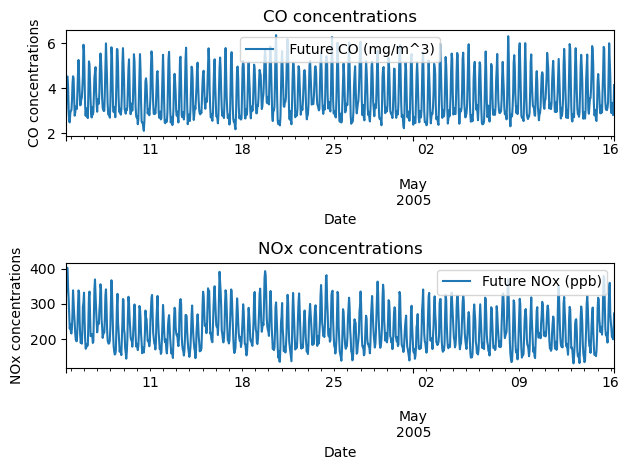

In [46]:
#Visualizing future predictions
plt.subplot(2,1,1)
true_predictions_gru['Future CO (mg/m^3)'].plot(title= 'CO concentrations',legend=True, label=' Future CO (mg/m^3)')
plt.xlabel('Date')
plt.ylabel('CO concentrations')


plt.subplot(2,1,2)
true_predictions_gru['Future NOx (ppb)'].plot(title= 'NOx concentrations',legend=True, label='Future NOx (ppb)')
plt.xlabel('Date')
plt.ylabel('NOx concentrations')

plt.tight_layout()

In [ ]:
#Putting predictions in a csv so the next algorithm does not have to run this notebook again
true_predictions_gru.index.name='Date'
true_predictions_gru.to_csv("GRU predictions.csv", index=True)